# Task 1

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Import raw data and merge the data

In [3]:
Nextbike_bochum= pd.read_csv("./dataset/bochum.csv")
Nextbike_leipzig = pd.read_csv("./dataset/leipzig.csv")
Nextbike = Nextbike_bochum.append(Nextbike_leipzig)

Nextbike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202697 entries, 0 to 185326
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   day            202697 non-null  object 
 1   time           202697 non-null  object 
 2   b_number       202697 non-null  int64  
 3   city           202697 non-null  object 
 4   trip_duration  202697 non-null  object 
 5   orig_lat       202697 non-null  float64
 6   orig_lng       202697 non-null  float64
 7   dest_lat       202697 non-null  float64
 8   dest_lng       202697 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 15.5+ MB


In [4]:
date_info_leipzig = pd.read_csv("./resources/leipzig-holidays/leipzig-holidays.csv",sep=";")
date_info_leipzig["date"] = pd.to_datetime(date_info_leipzig["date"],format="%d.%m.%Y").dt.date
date_info_leipzig.index = date_info_leipzig["date"]

## Correct Data Types

In [5]:
#Converting Trip Length to timedelta
Nextbike['trip_duration'] = pd.to_timedelta(Nextbike['trip_duration'])

#Converting start-time to datetime
Nextbike['timestamp'] = pd.to_datetime(Nextbike['day'] + ' ' +  Nextbike['time'])
Nextbike.drop(columns=['day','time'], inplace = True)

## Add columns for analysis

In [6]:
#Round datetime and extract possible categorisation attributes
Nextbike['timestamp_rounded'] = Nextbike['timestamp'].dt.floor('H')

Nextbike['weekday'] = Nextbike['timestamp_rounded'].dt.weekday
Nextbike['week'] = Nextbike['timestamp_rounded'].dt.isocalendar().week

Nextbike['Time'] = Nextbike['timestamp_rounded'].dt.time
Nextbike["Time"] = Nextbike["Time"].astype(str).str[:2].astype(int)

Nextbike["date"] = Nextbike.timestamp.dt.date
#Nextbike_clean["date_str"] = Nextbike_clean.timestamp.dt.date.astype(str)

#take trip duration in minutes, calculate 1€ per 30 minutes of usage
Nextbike["revenue"] = np.ceil((Nextbike.trip_duration.dt.total_seconds()/60) /30)


#output
Nextbike

,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,timestamp,timestamp_rounded,weekday,week,Time,date,revenue
0,683,bochum,0 days 00:10:00,51.489814,7.232856,51.479592,7.222239,2019-02-08 12:06:00,2019-02-08 12:00:00,4,6,12,2019-02-08,1.0
1,683,bochum,0 days 00:14:00,51.479592,7.222239,51.472366,7.250500,2019-02-10 01:58:00,2019-02-10 01:00:00,6,6,1,2019-02-10,1.0
2,683,bochum,0 days 00:28:00,51.472366,7.250500,51.479592,7.222239,2019-02-11 06:33:00,2019-02-11 06:00:00,0,7,6,2019-02-11,1.0
3,683,bochum,0 days 00:58:00,51.479592,7.222239,51.483023,7.215314,2019-02-11 13:31:00,2019-02-11 13:00:00,0,7,13,2019-02-11,2.0
4,683,bochum,0 days 00:22:00,51.483023,7.215314,51.479592,7.222239,2019-02-11 14:32:00,2019-02-11 14:00:00,0,7,14,2019-02-11,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185322,99979,leipzig,0 days 00:07:00,51.468822,11.290048,51.468547,11.289899,2019-05-25 10:58:00,2019-05-25 10:00:00,5,21,10,2019-05-25,1.0
185323,99979,leipzig,0 days 01:16:00,51.468756,11.289723,51.469324,11.289366,2019-05-27 09:32:00,2019-05-27 09:00:00,0,22,9,2019-05-27,3.0
185324,99979,leipzig,0 days 00:03:00,51.469044,11.289348,51.469093,11.289432,2019-05-27 11:02:00,2019-05-27 11:00:00,0,22,11,2019-05-27,1.0
185325,99982,leipzig,0 days 01:44:00,51.341165,12.365045,51.341065,12.365005,2019-02-11 11:47:00,2019-02-11 11:00:00,0,7,11,2019-02-11,4.0


## Split data for analysis

In [7]:
Nextbike_clean_l = Nextbike[Nextbike.city == "leipzig"]
Nextbike_clean_b = Nextbike[Nextbike.city == "bochum"]

leipzig = {"lng": 12.3741468,"lat": 51.340744}

city = leipzig
df = Nextbike_clean_l.copy()
date_info = date_info_leipzig.copy()

## Find out size of the fleet
The idea is that a bike is recognized as part of the fleet if it has been rented in the last 7 days. So the size of the fleet is the amount of unique Bike IDs that have records for the last 7 days. We calculate this on a daily level to be precise yet not too intense to compute.

In [8]:
factor = 7

start_date = df.date.min()
end_date = df.date.max()
delta = pd.to_timedelta("1d")

dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta



fleet_size = pd.DataFrame([], index = dates, columns = ["search_array","fleet_size"]) 

search_array = []
for index, row in fleet_size.iterrows():
    search_array.append(index)
    if len(search_array) > factor:
        search_array.pop(0)
    row['search_array'] = search_array[:] #This just helps see if everything goes as expected
    row['fleet_size'] = df[df.date.isin(search_array[:])].b_number.nunique()
    
fleet_size.drop(columns=["search_array"], inplace = True)

In [9]:
df_by_date = df.groupby("date").agg(
    revenue=('revenue', "sum"),
    trips=("b_number","count"),
    used_bikes=('b_number', pd.Series.nunique))

df_by_date_merged = df_by_date.join(fleet_size) #this does not include the missing days
df_by_date_merged["usage"] = df_by_date_merged["used_bikes"] / df_by_date_merged["fleet_size"]
df_by_date_merged = df_by_date_merged.rename(columns={"trips": "daily_trips","revenue":"daily_revenue", "used_bikes":"daily_used_bikes"})
df_by_date_merged = pd.merge( df_by_date_merged, date_info, left_index=True, right_index=True)

df_by_date_merged = df_by_date_merged.drop(columns=["date"])

In [10]:
df_by_hour = df.groupby("timestamp_rounded").agg(
    revenue=('revenue', "sum"),
    trips=("b_number","count"),
    date=("date","min"),
    weekday=("weekday","min"),
    week = ("week","min"),
    time = ("Time","min"),
    used_bikes=('b_number', pd.Series.nunique))


df_by_hour_merged = pd.merge(df_by_hour, df_by_date_merged, right_index=True, left_on='date')


df_by_hour_merged["usage"] = df_by_hour_merged["used_bikes"] / df_by_hour_merged["fleet_size"]
df_by_hour_merged["relative_trips"] = df_by_hour_merged["trips"] / df_by_hour_merged["daily_trips"]

df_by_hour_merged

,revenue,trips,date,weekday,week,time,used_bikes,daily_revenue,daily_trips,daily_used_bikes,fleet_size,usage,day_classifier,vacations,holiday,relative_trips
timestamp_rounded,,,,,,,,,,,,,,,,
2019-02-01 00:00:00,9.0,8,2019-02-01,4,5,0,8,785.0,659,256,256,0.03125,weekday,0,0,0.012140
2019-02-01 01:00:00,9.0,7,2019-02-01,4,5,1,7,785.0,659,256,256,0.0273438,weekday,0,0,0.010622
2019-02-01 02:00:00,7.0,2,2019-02-01,4,5,2,2,785.0,659,256,256,0.0078125,weekday,0,0,0.003035
2019-02-01 03:00:00,3.0,3,2019-02-01,4,5,3,3,785.0,659,256,256,0.0117188,weekday,0,0,0.004552
2019-02-01 04:00:00,9.0,8,2019-02-01,4,5,4,8,785.0,659,256,256,0.03125,weekday,0,0,0.012140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 19:00:00,116.0,91,2019-06-30,6,26,19,86,2182.0,1702,499,790,0.108861,weekend,0,0,0.053467
2019-06-30 20:00:00,104.0,87,2019-06-30,6,26,20,82,2182.0,1702,499,790,0.103797,weekend,0,0,0.051116
2019-06-30 21:00:00,82.0,66,2019-06-30,6,26,21,62,2182.0,1702,499,790,0.078481,weekend,0,0,0.038778


____

# Predictive Analytics

In [11]:
from math import radians, cos, sin, asin, sqrt 
def calculate_distance(lon1, lat1, lon2, lat2): 
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) 
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371 
    km = 6371* c 
    return km

In [12]:
#Calculating the best Raster Point that is closest to the city center
testset_weather = pd.read_csv("./weather-data/dwd-raster/target/ra190201_target.csv") 

distances_center = []
for index, row in testset_weather.iterrows():
        d = {
            "LON": row["LON"],
            "LAT": row["LAT"],
            "ID": row["ID"],
            "distance": calculate_distance(row["LON"], row["LAT"], leipzig["lng"], leipzig["lat"])
        } 
        distances_center.append(d)
distances_center = pd.DataFrame(distances_center)

raster_id = distances_center.iloc[distances_center["distance"].idxmin()]["ID"]

In [13]:
#Read in CDC Raster Data from single files and Filter for the calculated point
import os

path = './weather-data/dwd-raster/target/'
rain_data_all = pd.concat((pd.read_csv(path+filename) for filename in os.listdir(path)))

rain_data = rain_data_all[rain_data_all["ID"] == raster_id]
rain_data.index = dates #indexing
rain_data.drop(columns=["ID"],inplace=True) 

/Users/guotianxin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
#Meteostat Data read-in
meteostat_leipzig = pd.read_csv("./weather-data/meteostat-leipzig.csv") 
meteostat_leipzig.index = dates
meteostat_leipzig.drop(columns=["wpgt","wdir","date"],inplace=True)

meteostat_leipzig.isnull().sum().sort_values(ascending=False)

#plt.plot(rain_data.index,rain_data.VAL)
#plt.plot(meteostat_leipzig.index,meteostat_leipzig.prcp)

tsun    0
pres    0
wspd    0
snow    0
prcp    0
tmax    0
tmin    0
tavg    0
dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics

import warnings
# warnings.filterwarnings('ignore')

import random

%matplotlib inline

In [16]:
df_predictive = df_by_date_merged
df_predictive["weekday_dummy"] = df_predictive["day_classifier"].isin(["weekday"]).astype(int)
df_predictive = df_predictive.join(meteostat_leipzig)
df_predictive = df_predictive.drop(columns={"day_classifier","usage","daily_revenue","daily_used_bikes"})
df_predictive

#df_predictive.to_csv("../output.csv")

,daily_trips,fleet_size,vacations,holiday,weekday_dummy,tavg,tmin,tmax,prcp,snow,wspd,pres,tsun
date,,,,,,,,,,,,,
2019-02-01,659,256,0,0,1,0.7,-2.3,3.3,0.0,0,6,995.2,0
2019-02-02,526,329,0,0,0,1.2,0.7,1.6,0.0,0,5,997.3,0
2019-02-03,285,350,0,0,0,0.7,0.2,1.1,4.7,30,11,1013.9,0
2019-02-04,499,390,0,0,1,0.8,-1.6,4.7,0.0,30,9,1028.2,470
2019-02-05,573,421,0,0,1,1.4,-0.5,3.8,0.0,20,9,1027.9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,2552,785,0,0,1,29.4,21.5,36.6,0.0,0,14,1020.1,750
2019-06-27,2555,787,0,0,1,20.5,15.3,26.2,0.0,0,17,1023.9,768
2019-06-28,2857,789,0,0,1,18.2,13.5,24.0,0.0,0,7,1024.5,513


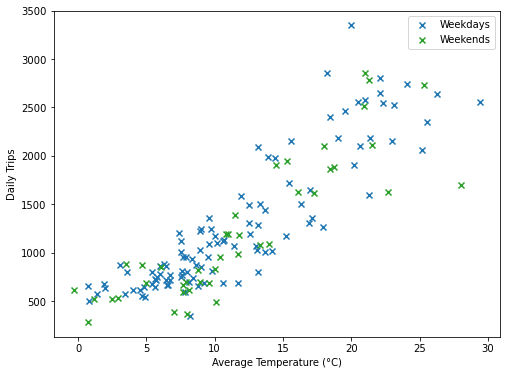

In [17]:
plt.figure(figsize = (8,6))
plt.scatter(df_predictive[df_predictive["weekday_dummy"] == 1]["tavg"],
            df_predictive[df_predictive["weekday_dummy"] == 1]["daily_trips"], marker="x", color = 'C0')
plt.scatter(df_predictive[df_predictive["weekday_dummy"] == 0]["tavg"],
            df_predictive[df_predictive["weekday_dummy"] == 0]["daily_trips"], marker="x", color = 'C2')
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Daily Trips")
plt.legend(["Weekdays","Weekends"])
plt.show()

We will use the DecisionTreeRegressor class in scikitlearnto fit and plot a decision tree regressor.

R^2:  0.7937689613793407


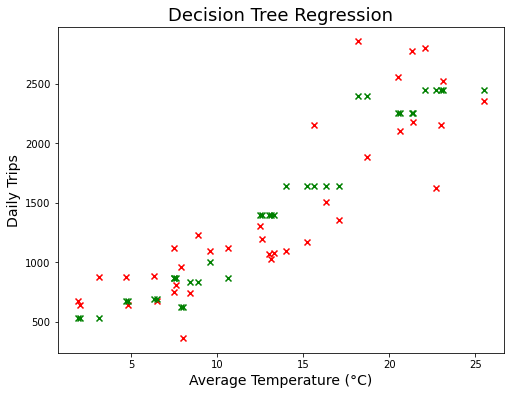

In [19]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def plot_tree_regression_line(tree_depth):

    Xt = df_predictive["tavg"].values
    Yt = df_predictive["daily_trips"].values

    X_train, X_test, y_train, y_test = train_test_split(Xt, Yt, test_size = 0.25)


    # Fit regression model
    # max_depth=tree_depth, criterion="mse"
    Tree_reg = DecisionTreeRegressor(min_samples_leaf=6, max_depth=8)
    Tree_reg.fit(X_train.reshape((-1,1)), y_train.reshape(-1,1))
    Y_pred = Tree_reg.predict(X_test.reshape((-1,1)))
    
    attributes = Tree_reg.tree_

    # plot
    plt.figure(figsize = (8,6))
    plt.title('Decision Tree Regression', fontsize = 18)
    plt.scatter(X_test, y_test, marker = "x", color = 'red')
    plt.scatter(X_test, Y_pred, marker = "x", color = 'green')
    #plt.plot(np.arange(-1,30,1), Tree_reg.predict(np.arange(-1,30,1).reshape((-1,1))), marker="x", color='C1')
    plt.xlabel("Average Temperature (°C)", fontsize = 14)
    plt.ylabel("Daily Trips", fontsize = 14)
    
    print("R^2: ", r2_score(y_test, Y_pred))

plot_tree_regression_line(2)

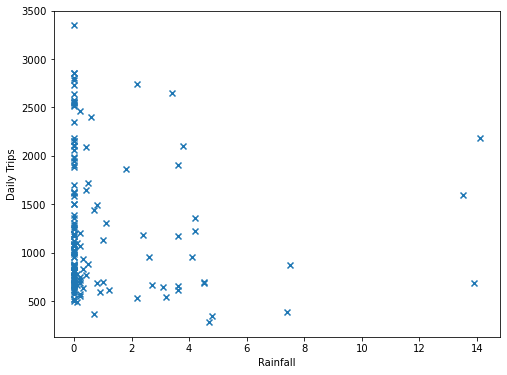

In [20]:
Xp = df_predictive["prcp"].values
Yp = df_predictive["daily_trips"].values

plt.figure(figsize = (8,6))
plt.scatter(Xp, Yp, marker="x")
plt.xlabel("Rainfall")
plt.ylabel("Daily Trips")
plt.show()

In [21]:
def plot_tree_regression_line(tree_depth):

    # Fit regression model (to full data)
    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,
                                    criterion="mse")
    Tree_reg.fit(Xp.reshape((-1,1)), Yp)
    Y_pred = Tree_reg.predict(Xp.reshape((-1,1)))
    
    attributes = Tree_reg.tree_

    # plot
    plt.figure(figsize = (8,6))
    plt.scatter(Xp, Yp, marker="x")
    plt.plot(np.arange(-0,20,1), Tree_reg.predict(np.arange(-0,20,1).reshape((-1,1))), marker="x", color='C1')
    plt.xlabel("Rainfall", fontsize=16)
    plt.ylabel("Daily Trips", fontsize=16)
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    print("R^2: ", r2_score(Yp, Y_pred))
   

number of nodes:  5
number of leafs:  3
R^2:  0.05584258166304523


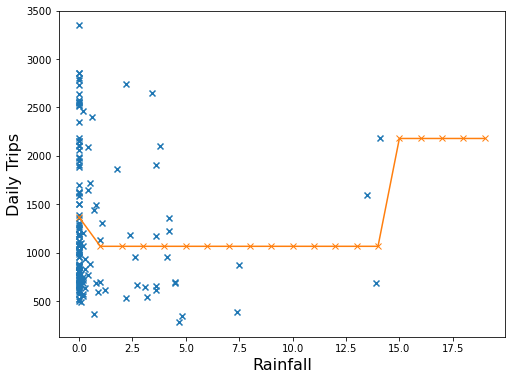

In [22]:
plot_tree_regression_line(2)

In [109]:
#define the regression tree

def plot_tree_regression_line(X, Y, tree_depth, xlabel, ylabel):
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)
    # Fit regression model
    #min_samples_leaf=6, max_depth = 8
    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth, min_samples_leaf=6,
                                    criterion="mse")
    Tree_reg.fit(X_train.reshape((-1,1)), y_train.reshape(-1,1))
    Y_pred = Tree_reg.predict(X_test.reshape((-1,1)))
    
    # plot
    plt.figure(figsize = (8,6))
    plt.title('Decision Tree Regression', fontsize = 18)
    plt.scatter(X_test, y_test, marker = "x", color = 'red')
    plt.scatter(X_test, Y_pred, marker = "x", color = 'green')
    #plt.plot(np.arange(-1,30,1), Tree_reg.predict(np.arange(-1,30,1).reshape((-1,1))), marker="x", color='C1')
    plt.xlabel(xlabel, fontsize = 14)
    plt.ylabel(ylabel, fontsize = 14)
    
    print("R^2: ", r2_score(y_test, Y_pred))

R^2:  0.7860678012429538


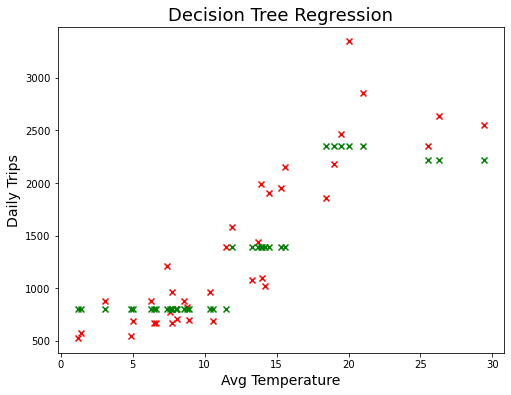

In [110]:
Xt = df_predictive["tavg"].values
Yt = df_predictive["daily_trips"].values

#X_train, X_test, y_train, y_test = train_test_split(Xt, Yt, test_size = 0.25)
plot_tree_regression_line(X = Xt, Y = Yt, tree_depth = 2, xlabel = "Avg Temperature", ylabel = "Daily Trips")

R^2:  -0.04761447847558298


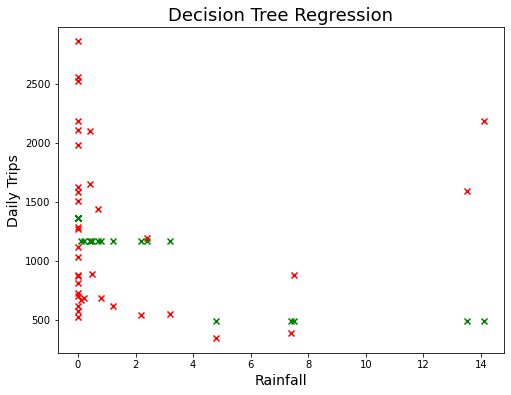

In [77]:
Xp = df_predictive["prcp"].values
Yp = df_predictive["daily_trips"].values

plot_tree_regression_line(X = Xp, Y = Yp, tree_depth = 2, xlabel = "Rainfall", ylabel = "Daily Trips")

R^2:  -0.013083815757275463


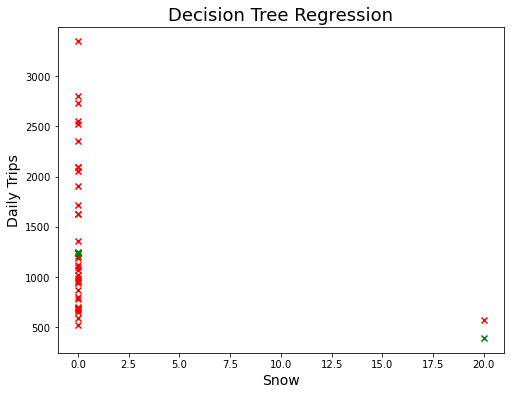

In [87]:
Xs = df_predictive["snow"].values
Ys = df_predictive["daily_trips"].values

plot_tree_regression_line(X = Xs, Y = Ys, tree_depth = 2, xlabel = "Snow", ylabel = "Daily Trips")

R^2:  -0.04032320283786084


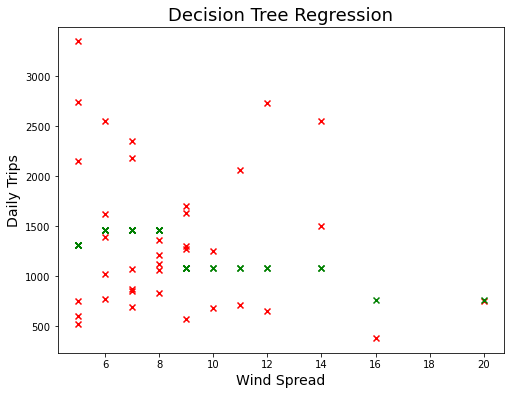

In [79]:
Xw = df_predictive["wspd"].values
Yw = df_predictive["daily_trips"].values

plot_tree_regression_line(X = Xw, Y = Yw, tree_depth = 2, xlabel = "Wind Spread", ylabel = "Daily Trips")

R^2:  -0.006901007376848289


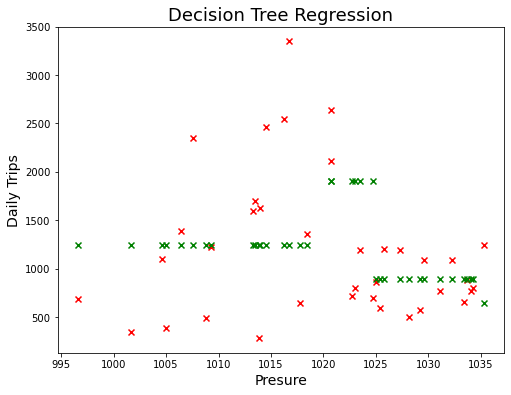

In [84]:
Xpre = df_predictive["pres"].values
Ypre = df_predictive["daily_trips"].values

plot_tree_regression_line(X = Xpre, Y = Ypre, tree_depth = 2, xlabel = "Presure", ylabel = "Daily Trips")

R^2:  -0.05708289305709302


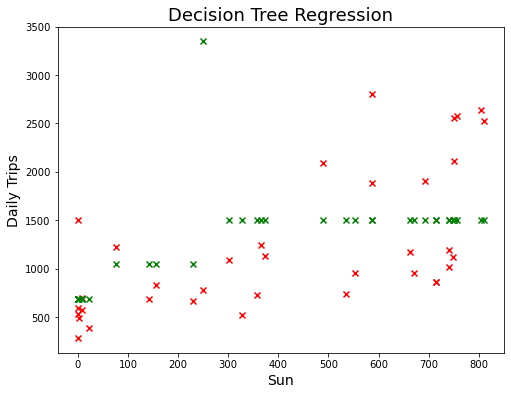

In [85]:
Xsun = df_predictive["tsun"].values
Ysun = df_predictive["daily_trips"].values

plot_tree_regression_line(X = Xsun, Y = Ysun, tree_depth = 2, xlabel = "Sun", ylabel = "Daily Trips")

<ipython-input-108-b91c8b366bf1>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_temperature, y_sun, zz, cmap=plt.cm.YlOrRd)


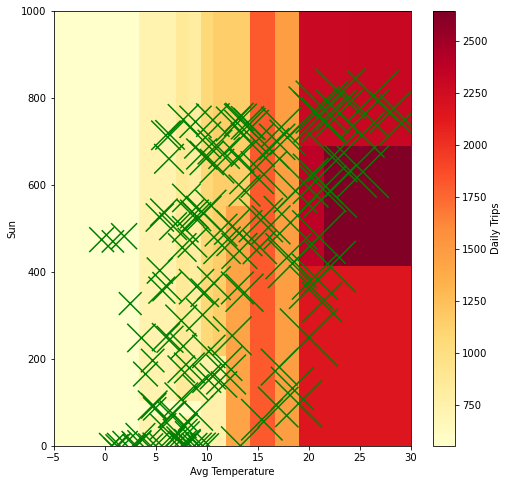

In [108]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

regressor = DecisionTreeRegressor(min_samples_leaf=6, max_depth=8)
regressor.fit(df_predictive[['tavg', 'tsun']], df_predictive['daily_trips'])

nx = 30

ny = 30

# creating a grid of points

x_temperature = np.linspace(-5, 30, nx) # min avg temperature -5, max 30

y_sun = np.linspace(0, 1000, ny) # min rainfall 0, max 20

xx, yy = np.meshgrid(x_temperature, y_sun)

# evaluating the regressor on all the points

z_trips = regressor.predict(np.array([xx.flatten(), yy.flatten()]).T)

zz = np.reshape(z_trips, (nx, ny))

fig = plt.figure(figsize=(8, 8))
# plotting the predictions
plt.pcolormesh(x_temperature, y_sun, zz, cmap=plt.cm.YlOrRd)
plt.colorbar(label='Daily Trips') # add a colorbar on the right
# plotting also the observations
plt.scatter(df_predictive['tavg'], df_predictive['tsun'], s = df_predictive['daily_trips'], marker = 'x', c='g')
# setting the limit for each axis
plt.xlim(np.min(x_temperature), np.max(x_temperature))
plt.ylim(np.min(y_sun), np.max(y_sun))
plt.xlabel('Avg Temperature')
plt.ylabel('Sun')
plt.show()